In [583]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import numpy as np

from scipy.stats import pearsonr

import os
import math

Some auxiliary functions for working with pandas series

In [584]:
def date_from_datetime_series(datetime):
    return datetime.date()

In [585]:
def time_from_datetime_series(datetime):
    return datetime.time()

In [586]:
def parse_trends_timestamp(timestamp):
    datetime_str = timestamp.split(' ')
    return datetime.datetime.fromisoformat(datetime_str[0].split('/')[2]+'-'+datetime_str[0].split('/')[0]+'-'+datetime_str[0].split('/')[1]+ ' ' + datetime_str[1])

In [587]:
def parse_feedback_timestamp(timestamp):
    date_str = timestamp.split('T')[0]
    time_str = timestamp.split('T')[1]

    return datetime.datetime.fromisoformat(date_str + ' ' + time_str[:5])

### Loading Feedback data


In [588]:
feedback_room_df = pd.read_csv('../data/abschluss-daten/feedback_room.csv')
device_df = pd.read_csv('../data/abschluss-daten/device.csv')
participant_df = pd.read_csv('../data/abschluss-daten/participant.csv')

In [589]:

for column_name in device_df.columns:
    if 'timestamp' in column_name or 'At' in column_name:
        device_df[column_name] = device_df[column_name].dropna().apply(parse_feedback_timestamp)

for column_name in participant_df.columns:
    if 'timestamp' in column_name or 'At' in column_name:
        participant_df[column_name] = participant_df[column_name].dropna().apply(parse_feedback_timestamp)

for column_name in feedback_room_df.columns:
    if 'timestamp' in column_name or 'At' in column_name:
        feedback_room_df[column_name] = feedback_room_df[column_name].dropna().apply(datetime.datetime.fromisoformat)


### Loading Temperature & Air quality data

Loading data is done as a batch, a dataframe variable is created for each file with its name in the form rx_xx_df according to the file read.

In [590]:
dir_list = os.listdir('../data/Trends Smart City/0EG') + os.listdir('../data/Trends Smart City/1OG') + os.listdir('../data/Trends Smart City/2OG') + os.listdir('../data/Trends Smart City/3OG')

In [591]:
df_names = []

for filename in dir_list:
    split_name = filename.lower().split(' ')
    further_split_name = split_name[0].split('-')
    df_name = further_split_name[1]+'_'+further_split_name[2]

    if 'Lufttemp' in filename:
        df_name += '_temp_df'

    else:
        df_name += '_qual_df'

    #df_name = '_'.join(further_split_name[1:])+'_df'
    df_names.append(df_name)


    if further_split_name[1] == 'r0':
        globals()[df_name] = pd.read_csv('../data/Trends Smart City/0EG/'+filename,sep=';',header=0,usecols = [i for i in range(3)],names=['timestamp','value','reduced'])

    elif further_split_name[1] == 'r1':
        globals()[df_name] = pd.read_csv('../data/Trends Smart City/1OG/'+filename,sep=';',header=0,usecols = [i for i in range(3)],names=['timestamp','value','reduced'])

    elif further_split_name[1] == 'r2':
        globals()[df_name] = pd.read_csv('../data/Trends Smart City/2OG/'+filename,sep=';',header=0,usecols = [i for i in range(3)],names=['timestamp','value','reduced'])

    elif further_split_name[1] == 'r3':
        globals()[df_name] = pd.read_csv('../data/Trends Smart City/3OG/'+filename,sep=';',header=0,usecols = [i for i in range(3)],names=['timestamp','value','reduced'])

    globals()[df_name]['timestamp'] = globals()[df_name]['timestamp'].apply(parse_trends_timestamp)

Changing the room name format to match that used in the trends dataset

In [592]:
def parse_roomName(roomName):
    if 'VS' not in roomName:
        return

    roomName = roomName[3:]
    roomName = roomName.split('.')
    return 'r'+'_'.join(roomName)



In [593]:
feedback_room_df['roomName'] = feedback_room_df['roomName'].apply(parse_roomName)

### Splitting feedback data

In [594]:
daily_airDraft_df = feedback_room_df[['daily_airDraft_timestamp','daily_airDraft_value','roomName']].dropna()
daily_ambientSounds_df = feedback_room_df[['daily_ambientSounds_timestamp','daily_ambientSounds_value','roomName']].dropna()
daily_artificialLight_df = feedback_room_df[['daily_artificialLight_timestamp','daily_artificialLight_value','roomName']].dropna()
daily_dayLight_df = feedback_room_df[['daily_dayLight_timestamp','daily_dayLight_value','roomName']].dropna()
daily_smell_df = feedback_room_df[['daily_smell_timestamp','daily_smell_value','roomName']].dropna()
daily_studentsAdherence_df = feedback_room_df[['daily_studentsAdherence_timestamp', 'daily_studentsAdherence_value','roomName']].dropna()
daily_studentsFocused_df = feedback_room_df[['daily_studentsFocused_timestamp', 'daily_studentsFocused_value','roomName']].dropna()
daily_studentsIrritated_df = feedback_room_df[['daily_studentsIrritated_timestamp', 'daily_studentsIrritated_value','roomName']].dropna()
daily_studentsMotivated_df =feedback_room_df[['daily_studentsMotivated_timestamp', 'daily_studentsMotivated_value','roomName']].dropna()

hourly_airQuality_df = feedback_room_df[['hourly_airQuality_timestamp', 'hourly_airQuality_value','roomName']].dropna()
hourly_humidity_df = feedback_room_df[['hourly_humidity_timestamp', 'hourly_humidity_value','roomName']].dropna()
hourly_indoorClimate_df = feedback_room_df[['hourly_indoorClimate_timestamp', 'hourly_indoorClimate_value','roomName']].dropna()
hourly_temperature_df = feedback_room_df[['hourly_temperature_timestamp', 'hourly_temperature_value','roomName']].dropna()

In [595]:
daily_feedback_data = [daily_airDraft_df,daily_ambientSounds_df,daily_artificialLight_df,daily_dayLight_df,daily_smell_df,daily_studentsAdherence_df,daily_studentsFocused_df,daily_studentsIrritated_df,daily_studentsMotivated_df]

In [596]:
hourly_feedback_data = [hourly_airQuality_df,hourly_humidity_df,hourly_indoorClimate_df,hourly_temperature_df]

## Removing all daily feedback entries before classes would have occured that day

In [597]:
minimum_time = datetime.time(hour=10,minute=0) #10 am

In [598]:
for dataframe in daily_feedback_data:
    dataframe = dataframe[dataframe.iloc[:, 0] .apply(time_from_datetime_series) > minimum_time] 

## Plotting
Plotting scatterplots for values from feedback dataset against the max temp/qual reading from the room air data

Here only points for which we have the following are plotted: 
- Temp/Qual data for that particular room
- Points for which have have temp/qual data from the past hour for that room

Only a small percentage of the data points we have meets the above criteria therefore these plots might not be indicative of the actual data


^ Change the above to the daily room averages

3 is happiest

2 = 4

1 = 5

In [599]:
def get_daily_average_value(timestamp,room,type='temp'):
    """
    Arguments: time and room from the feedback dataset,
        type: "temp" or "qual"
    """
    #skip rooms for which we don't have files for
    if room+'_'+type+'_df' not in df_names:
        #print('No data for room')
        return np.nan

    #Loading room air data
    room_data = globals()[room+'_'+type+'_df'].sort_values(by='timestamp')

    #calculating daily average
    mask = (room_data['timestamp'].apply(date_from_datetime_series) == timestamp.date())
    room_data = room_data.loc[mask]
    
    
    #If no value for that day return None 
    if len(room_data['value']) == 0:
        print("No data for day")
        return np.nan #no data

    #return mean daily value
    return room_data['value'].mean()


In [600]:
def get_mean_past_hour_value(timestamp,room,type='temp'):
    """
    Arguments: time and room from the feedback dataset,
        type: "temp" or "qual"
    """
    #skip rooms for which we don't have files for
    if room+'_'+type+'_df' not in df_names:
        #print(room)
        #print('No data for room')
        return np.nan

    #Loading room air data
    room_data = globals()[room+'_'+type+'_df'].sort_values(by='timestamp')

    #calculating daily average
    mask = (room_data['timestamp'] >= timestamp - datetime.timedelta(hours=1)) & (room_data['timestamp'] <= timestamp)
    room_data = room_data.loc[mask]
    
    
    #If no value for that day return None 
    if len(room_data['value']) == 0:
        #print("No data for day")
        return np.nan #no data

    #return mean daily value
    return room_data['value'].mean()


In [601]:
type_dict = {'temp':"temperature",'qual':"quality"}

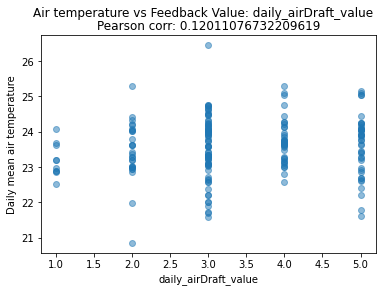

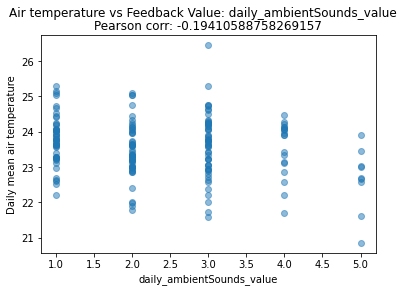

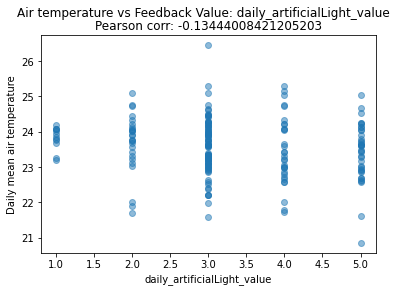

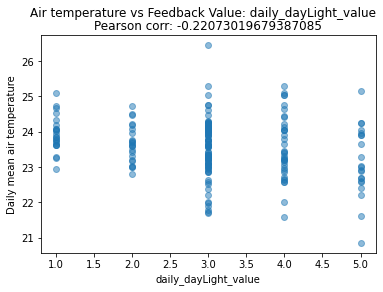

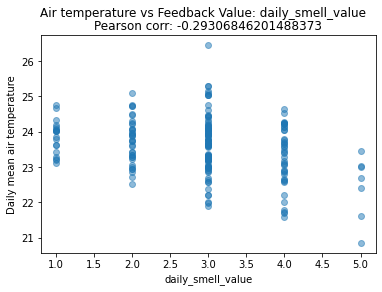

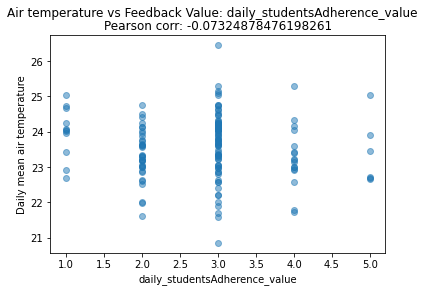

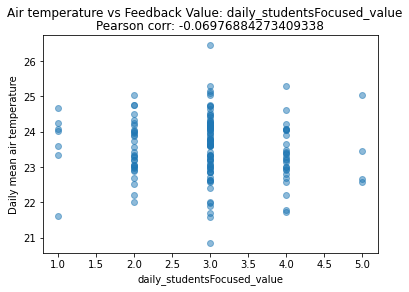

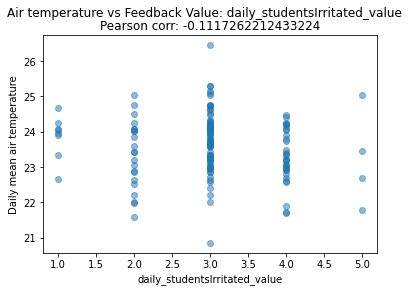

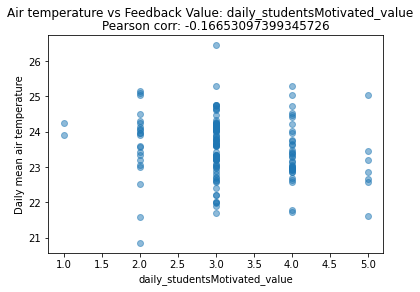

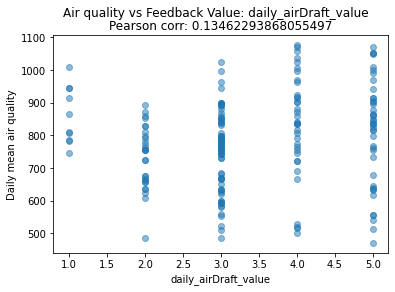

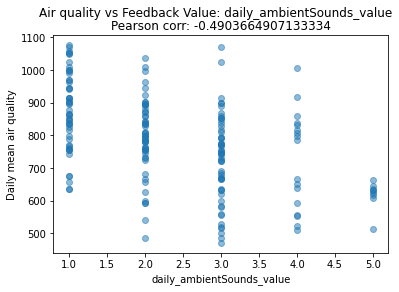

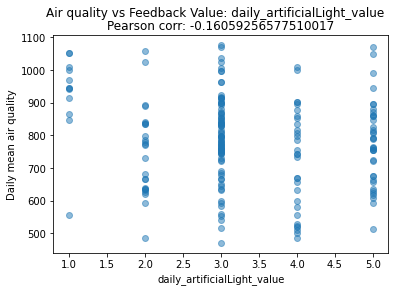

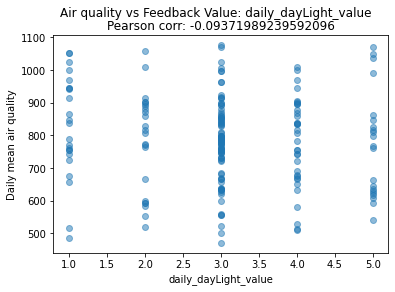

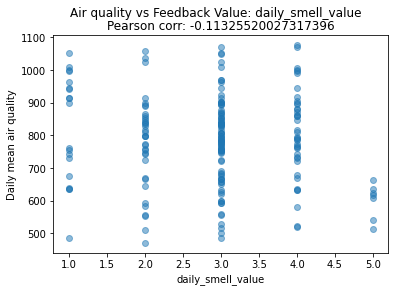

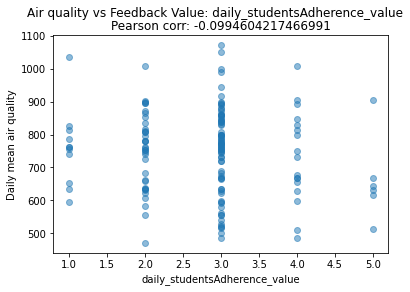

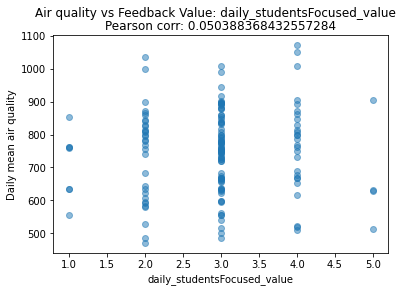

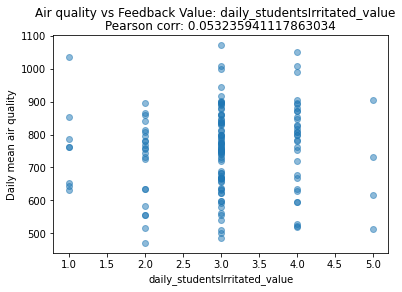

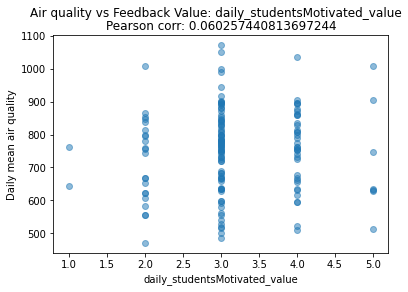

In [602]:
for type in ['temp','qual']:
    
    #for each feedback type
    for dataframe in [daily_airDraft_df,daily_ambientSounds_df,daily_artificialLight_df,daily_dayLight_df,daily_smell_df,daily_studentsAdherence_df,daily_studentsFocused_df,daily_studentsIrritated_df,daily_studentsMotivated_df]:
        #print(dataframe.columns)
        x = dataframe[dataframe.columns[1]] #feedback value
        y = []

        for timestamp, room in zip(dataframe[dataframe.columns[0]],dataframe[dataframe.columns[2]]): #0=timestamp, 2=roomName
            #max getting room air temp/qual for that room in the past hour
            y.append(get_daily_average_value(timestamp,room,type))

        plt.figure()
        plt.scatter(x, y, alpha=0.5)

        plt.suptitle("Air "+type_dict[type] + " vs Feedback Value: "+ dataframe.columns[1])
 

        #dropping nan values and calculating correlation between x and y
        plt.title("Pearson corr: "+str(pd.DataFrame({"x":x, 'y':y}).dropna().corr(method='pearson')['x']['y']))
        
        plt.xlabel(dataframe.columns[1])
        plt.ylabel("Daily mean air "+type_dict[type])
        
        plt.savefig("../plots/room_air_"+type+"/"+dataframe.columns[1]+".png")
        plt.show()




For our hourly data, a rating of 3 is the best, 2 and 4 slighty worse, 1 and 5 the worst

In [607]:
def make_3_best_score(score):
    if score == 3:
        return 3
    elif score == 2 or score == 4:
        return 2 #a slightly worse score
    elif score == 1 or score == 5:
        return 1 #a slightly worse score

In [608]:
for type in ['temp','qual']:
    
    #for each feedback type
    for dataframe in [hourly_airQuality_df,hourly_humidity_df,hourly_indoorClimate_df,hourly_temperature_df]:

        #dataframe.columns[1] is the feedback value
        dataframe['new_value'] = dataframe.columns[1].apply(make_3_best_score)
        #print(dataframe.columns)
        x = dataframe['new_value'] #feedback value
        y = []

        for timestamp, room in zip(dataframe[dataframe.columns[0]],dataframe[dataframe.columns[2]]): #0=timestamp, 2=roomName
            #getting mean air temp/qual for that room in the past hour
            y.append(get_mean_past_hour_value(timestamp,room,type))

        plt.figure()
        plt.scatter(x, y, alpha=0.5)

        plt.suptitle("Air "+type_dict[type] +" vs Feedback Value: "+ dataframe.columns[1])#+ dataframe.columns[1])

        #dropping nan values and calculating correlation between x and y
        plt.title("Pearson corr: "+str(pd.DataFrame({"x":x, 'y':y}).dropna().corr(method='pearson')['x']['y']))
        
        plt.xlabel(dataframe.columns[1])
        plt.ylabel("Max "+type_dict[type]+ " in past hour")
        
        plt.savefig("../plots/room_air_"+type+"/"+dataframe.columns[1]+".png")
        plt.show()


AttributeError: 'str' object has no attribute 'apply'